# Atmospheric modelling

Following on from the cloud simulations and PCA of the cloud spectrum we are next going to attempt to emulate the libRadtran atmospheric model. Before we do that we first have to inspect the parameter space over which the model will have to simulate transmittance, atmospheric path reflectance and spherical albedo. These are the three variables we need for our forward model of TOA reflectance given in addition a certain surface reflectance. The parameter space will be inspected by setting up a 3D grid with 2 varying parameters on the x and y axis, and either the integral of reflectance over a spectral region or the reflectance at a specific wavelength as the z axis, or even the difference or normalized difference between inside the absorption band and outside. The covariance of parameters can thus be inspected. The parameters we need for our model are: water vapour content (WVC), aerosol optical thickness (AOT) at 550 nm, surface pressure (press). Altitude is not included as this is a prescribed parameter and will have a similar effect to surface pressure on the spectrum. View and solar directions are also not included as these are also prescribed and each configuration of view and solar angle will require a separate emulator, thus not be included in the modelled surface within each emulator. 

After the simulation of some covariance between parameters to see its affect on atmospheric variables, we need to create a PCA of the different atmospheric RT variables ie. double transmittance ($TT$), spherical albedo ($\alpha$) and atmospheric path reflectance ($\rho_{atm}$). Thus is will be done over the full expected parameter space range. A literature review and where possible auxiliary datasets will provide some insight into ranges and possibly distributions of parameters used. This was done as part of the cloud PCA and these distributions can be used again. Altitude was not included but can be included this time with a new analysis of altitude ranges. A global DTM can be loaded and altitudes can be binned to estimate a distribution type. 

The PC will be used to create our emulator. Instead of emulating the relationship between our parameters and the variables, we will be emulating the relationship between our parameters and the coefficients of the PCs which will give us the best combination to reinstate our variable spectrum. In order to do this we would need to create a LUT of parameters against PC coefficients which will be what the emulator requires. But before we do this we would need to create a training dataset for the PCs then use this same dataset to optimize by minimizing the PC model with retrieved coefficients against the libRadtran training dataset. This will provide a list of PC coefficients against atmospheric parameters. Using this we can reconstruct any spectrum for the variables using the emulator as forward model which requires the atmospheric parameters and provides the best PC coefficients to reinstate the forward model using PCs.


In [1]:
# do some preparation for all the cells below

import numpy as np
import pandas as pd
import os
import matplotlib.pylab as plt
%matplotlib inline
import scipy as sc
#import scipy.stats as stats
import pdb
from scipy import signal

fwhm = 0.4931 # fwhm of slit function nm
w_slit = 2 # width of slit function in nm

def slit_smooth(lam, spectrum, fwhm, width):
    '''
    Function that applies the gaussian slit function with known FWHM to spectrum.
    It will replace the boundaries of the smoothed spectrum which are affected by
    zero padding with the original spectrum.
    Input:
    lam - wavelenght array in nm
    spectrum - the spectrum to convolve
    fwhm - the full width half maximum of the gaussian in nm
    width - the width of the slit function in nm
    Output:
    convol - smoothed spectrum
    '''
    resol = np.average(np.diff(lam)) # average spectral resol of model in nm
    intervals = np.ceil((width / resol)+1) # the number of intervals in the width of slit
    slit = signal.gaussian(intervals, fwhm/2.3548201*intervals/width)
    convol = signal.fftconvolve(spectrum, slit/np.sum(slit), mode='same')
    hwidth = (intervals-1)/2
    convol[:intervals] = spectrum[:intervals]
    convol[-intervals-1:] = spectrum[-intervals-1:]
    return convol

## Parameters vs RT variable space analysis

The aim of the exercise is to see how variations in the parameters affect the variables used in our RT equation for TOA reflectance. This is where the effects of changes in parameter space will be compared with changes in the variables eg. change of WVC against AOT and how this affects $TT$. Several libRadtran simulations need to be done at a fixed location in the other parameters eg. press. We can select for example 3 locations in press space like close to the upper, middle and lower limit of the press space, and vary the other 2 parameters over their full range. The z axis in our plots could be the integrated value of $TT$ or at a specific part of the $TT$ spectrum or a ration between 2 parts such as inside and outside of the water vapour absorption band. It would be faster to run the model only on a few selected wavelengths, but if an integrated value is needed, better to run the model over the full spectrum, and then integrate or select the wavelengths required. 

## PCA of the RT variables

A Principle Componant Analysis of $TT$, $\alpha$ and $\rho_{atm}$ over the full parameter space is required. We have distributions of AOT, press and WVC but do not have one for alt. To start off we have to get a distribution of the global surface altitude. For this a SRTM global DEM was downloaded and altitudes over the land mass were binned into a histogram. A distribution type was selected based on the shape of the histogram and test simulations with the distribution of the best fit selected. In order to reduce the amount of simulations for solar zenith angles a usefull thing to have would be the range of solar zenith angles we could expect to encounter for the MetopA orbit and the swathe of the GOME-2 sensor.

### Solar zenith angle range

In [212]:
# functions to calculate bearing from 2 coordinates and coordinate from coordinate, bearing and distance.
import pdb

def dms_dec(dms):
    '''A function that converts degrees minutes seconds to decimal degrees.
    Input: dms
    Output: dec
    ''' 
    neg = True if dms < 0.0 else False
    dms = np.abs(dms)
    dmsstr = '%.10f' % (dms)
    degrees = np.trunc(dms)
    right = dmsstr.split('.')[1]
    minutes = right[:2]
    seconds = right[2:]
    dec = degrees + np.float(minutes)/60 + np.float(seconds)/60/60/(10**(len(seconds)-2))
    dec = -dec if neg else dec
    return dec    

def add_deg(deg1, deg2):
    '''Adds two angles in decimal degrees and convert to 0 to 360 degree convention.
    Both angles have to be between 0 and 360.
    Input: deg1, deg2
    Output: deg360
    '''
    deg = deg1 + deg2
    deg = deg if deg < 360 else deg - 360
    return deg

def sub_deg(deg1, deg2):
    '''Subtracts two angles in decimal degrees and convert to 0 to 360 degree convention.
    Both angles have to be between 0 and 360.
    Input: deg1, deg2
    Output: deg360
    '''
    deg = deg1 - deg2
    deg = deg if deg >= 0 else 360 + deg
    return deg

# standard earth radius
EARTH_RADIUS = 6371.00

def geo_coord(lon, lat, bearing, distance):
    '''A function to calculate the geographic coordinates of a point based on the distance from 
    another point, its bearing from that point and its distance from that point. Angles are in
    decimal degrees and distance in kms.
    Input: lat, lon, bearing, distance
    Output: tuple(new_lat, new_lon)
    '''
    # convert Latitude and Longitude
    # into radians for calculation
    latitude = np.radians(lat)
    longitute = np.radians(lon)

    # calculate next latitude
    next_latitude = np.arcsin(np.sin(latitude) *
                    np.cos(distance/EARTH_RADIUS) +
                    np.cos(latitude) *
                    np.sin(distance/EARTH_RADIUS) *
                    np.cos(np.radians(bearing)))

    # calculate next longitude
    next_longitude = longitute + (np.arctan2(np.sin(np.radians(bearing)) *
                                             np.sin(distance/EARTH_RADIUS) *
                                             np.cos(latitude),
                                             np.cos(distance/EARTH_RADIUS) -
                                             np.sin(latitude) *
                                             np.sin(next_latitude)
                                            )
                                 )

    # convert points into decimal degrees
    new_lat = np.degrees(next_latitude)
    new_lon = np.degrees(next_longitude)
    
    return (new_lon, new_lat)

def geo_bearing(lon1, lat1, lon2, lat2):
    '''A function that calculates the bearing and distance between two geographic coordinates.
    Based on Haversine forumula. Angles are in decimal degrees and distance in kms.
    Input: lat1, lon1, lat2, lon2
    Output: tuple(bear, dist)
    '''
    # convert decimal degrees to radians 
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    
    dist = c * EARTH_RADIUS
    
    bear =np.arctan2(np.sin(lon2-lon1)*np.cos(lat2) , np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(lon2-lon1))
    bear = np.rad2deg(bear)
    bear = (bear + 360.) % 360. # for negative angles
    
    return (bear, dist)

In [214]:
# run a simulation of the sub satellite solar zenith angle over the year 2007. will need to get the position every couple
# of minutes and then calculate the sub-satellite point for that moment and calculate the solar zenith angle. write it
# to a pandas dataframe. The information needed is solar zenith, lat, lon, utc time. 
# easy enough to convert this to an extreme of swathe solar zenith by spherical trigonometry. if we know the bearing
# between 2 points and assume a swathe bearing perpendicular to this, and know the swathe width we can work out the 
# positions of the 2 exteme points on the swathe. Only need to work out the solar zenith angle at these 2 points.
# swath is 1920 km.

from pyorbital.orbital import Orbital
from pyorbital import astronomy
from dateutil import rrule
from datetime import datetime, timedelta
import pandas as pd

# create the time list
times = []
# change start and end dates to reduce processing during testing
start = datetime(2007, 1, 1, 0, 0, 0) #start = datetime(2007, 1, 1, 0, 0, 0)
end = datetime(2007, 12, 31, 23, 59, 59) #end = datetime(2007, 12, 31, 23, 59, 59)
for dt in rrule.rrule(rrule.MINUTELY, interval=10, dtstart=start, until=end):
    times.append(dt)

# create the solar zenith angle dataframe
columns = ['lat', 'lon', 'szen']
pos = ['left', 'centre', 'right']*len(times)

times3 = [x for pair in zip(times,times,times) for x in pair]
szen_df = pd.DataFrame(index=[times3, pos], columns=columns)
szen_df.index.names = ['time', 'pos']
szen_df.name = 'subsat_sol_zen'

# read in tles into series based on time as index
fn = 'sat29499.txt'
tle_l = open(fn).read().splitlines()
tle_l = tle_l[5:]
tle_l = zip(*[iter(tle_l)]*2)
dates = [datetime(int('20'+i[0][18:20])-1, 12, 31) + timedelta(days=(float(i[0][20:32]))) for i in tle_l]
tle_sr = pd.Series(tle_l, index=dates)
tle_sr.index.name = 'dates'
tle_sr.name = 'TLEs'

# work out the solar zenith angles depending on subsatellite and extreme swath positions
olat = False
olon = False
hswath = 1920./2 # half the swath

for time in times:
    tle = tle_sr.asof(time)
    #
    if isinstance(tle, tuple):
        pass
    elif np.isnan(tle):
        continue
    # read orbital tle data
    orb = Orbital("Metop-A", line1=tle[0] , line2=tle[1] )
    # the subsatellite point
    lon, lat, alt = orb.get_lonlatalt(time)
    szen = astronomy.sun_zenith_angle(time, lon, lat)
    pos = 'centre'
    szen_df.ix[time].ix[pos].lon = lon
    szen_df.ix[time].ix[pos].lat = lat
    szen_df.ix[time].ix[pos].szen = szen
    # the left and right extreme swath points
    if olat==False:
        olat = lat
        olon = lon
        continue
    bear = geo_bearing(lon, lat, olon, olat)[0] # in reverse, back to previous point
    bear = add_deg(bear, 180.) # corrected going forward
    # the left
    lbear = sub_deg(bear, 90.)
    llon, llat = geo_coord(lon, lat, lbear, hswath)
    lszen = astronomy.sun_zenith_angle(time, llon, llat)
    pos = 'left'
    szen_df.ix[time].ix[pos].lon = llon
    szen_df.ix[time].ix[pos].lat = llat
    szen_df.ix[time].ix[pos].szen = lszen
    # the right
    rbear = add_deg(bear, 90.)
    rlon, rlat = geo_coord(lon, lat, rbear, hswath)
    rszen = astronomy.sun_zenith_angle(time, rlon, rlat)
    pos = 'right'
    szen_df.ix[time].ix[pos].lon = rlon
    szen_df.ix[time].ix[pos].lat = rlat
    szen_df.ix[time].ix[pos].szen = rszen
    
    olat = lat.copy()
    olon = lon.copy()

In [293]:
# save the satellite orbit dataframe to a file
fn = 'orbit_szen.pkl'
szen_df.save(fn)

In [ ]:
# load the dataframe if required
fn = 'orbit_szen.pkl'
szen_df = pd.load(fn)

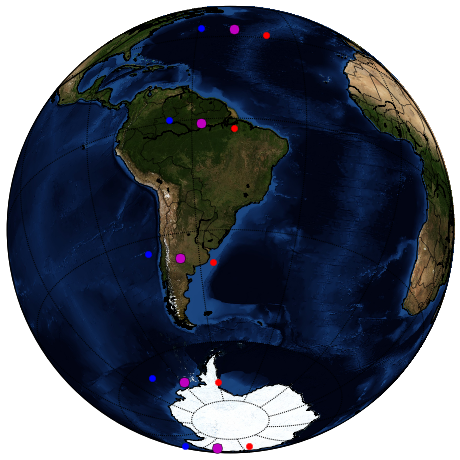

In [242]:
# Test the orbits to see if agrees with our GOME-2 observations and it does. I checked the solar zeniths
# at the extremes of the swath and it agrees to within 1 degree. The orbit below is the same used for our
# Amazon data.

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import numpy as np
%matplotlib inline

start = datetime(2007, 1, 25, 12, 49, 0)
end = datetime(2007, 1, 25, 14, 30, 0)
projection = 'ortho' # 'robin', 'ortho'. ortho doesn't accept text labels. use cyl or robin
lat_0 = -30. # latitude of viewpoint
lon_0 = -50. # longitude of viewpoint

# due to making a copy of a subset of a dataframe keeps the original index, need to move the index into
# the columns, do the subselection and then move it back into the index, thus keeping only the 
# index subset instead of the original index.
orb_df = szen_df.reset_index(level='pos').loc[start:end].set_index('pos', append=True)

# make sure the value of resolution is a lowercase L,
#  for 'low', not a numeral 1

my_map = Basemap(projection=projection, lat_0=lat_0, lon_0=lon_0,
              resolution='l', area_thresh=1000.0) 

plt.figure(figsize=(12,8))
 
my_map.drawcoastlines()
my_map.drawcountries()
#my_map.fillcontinents(color='coral')
my_map.bluemarble()
my_map.drawmapboundary()
 
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))

llons = orb_df['lon'].xs('left', level='pos').values
llats = orb_df['lat'].xs('left', level='pos').values
clons = orb_df['lon'].xs('centre', level='pos').values
clats = orb_df['lat'].xs('centre', level='pos').values
labels = orb_df.index.levels[0]
rlons = orb_df['lon'].xs('right', level='pos').values
rlats = orb_df['lat'].xs('right', level='pos').values

xl,yl = my_map(llons, llats)
my_map.plot(xl, yl, 'r.', markersize=12)
xc,yc = my_map(clons, clats)
my_map.plot(xc, yc, 'mo', markersize=10)
# offsets
if projection!='ortho':
    off = 2
    for x, y, label in zip(xc, yc, labels):
        plt.text(x+off, y+off, label.strftime('%Y-%m-%d %H:%M:%S'))
xr,yr = my_map(rlons, rlats)
my_map.plot(xr, yr, 'b.', markersize=12)

plt.show()

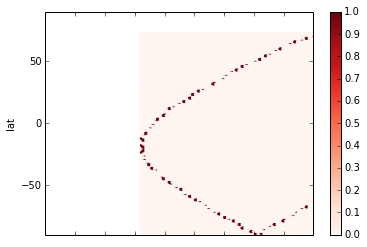

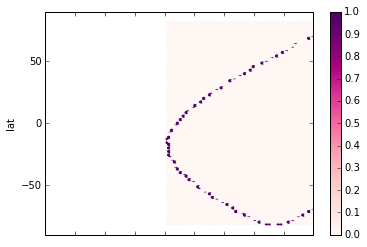

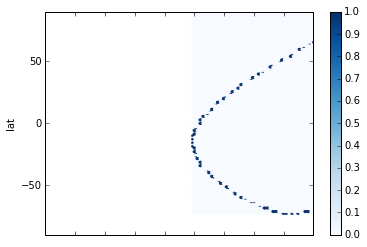

In [292]:
# plot the latitudes against solar zenith angles
%matplotlib inline

#plt.hexbin(x=szen_df.dropna().szen.values, y=szen_df.dropna().lat.values, cmap='Reds')
#plt.xlabel('szen')
#plt.ylabel('lat')
#plt.xlim(0,90)
#plt.ylim(-90,90)

szen_df.xs('left', level='pos').plot(x='szen', y='lat', xlim=(0,90), ylim=(-90,90), kind='hexbin', colormap='Reds' )
szen_df.xs('centre', level='pos').plot(x='szen', y='lat', xlim=(0,90), ylim=(-90,90), kind='hexbin', colormap='RdPu' )
szen_df.xs('right', level='pos').plot(x='szen', y='lat', xlim=(0,90), ylim=(-90,90), kind='hexbin', colormap='Blues' )

### Global altitude distribution

<matplotlib.colorbar.Colorbar instance at 0x7fa7ea976320>

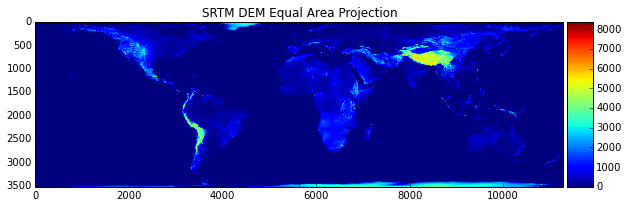

In [32]:
# DEM data in topo30_equal_area_land.tif
# The DEM was reprojected into a cylindrical equal area projection in order to make the sampled pixel size
# more representative of real world areas.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from osgeo import gdal

fn = '../../Data/DEM/topo30_equal_area_land_coarse.tif'
ds = gdal.Open(fn)
dem = np.array(ds.GetRasterBand(1).ReadAsArray())

plt.figure(figsize=(10,7))
ax = plt.gca()
plt.title('SRTM DEM Equal Area Projection')
im = plt.imshow(dem)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

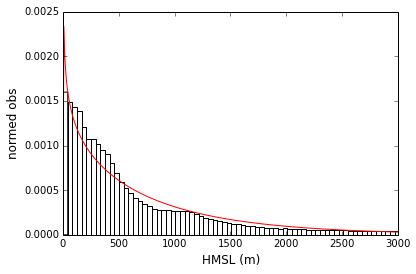

(2.2294640000085049, 762.57514668790009, 848.95216904700931)


In [130]:
# fit the data to a distribution
import scipy.stats as stats

dem_flat = np.array(dem).flatten()
dem_flat = dem_flat[~np.isnan(dem_flat)]
dem_flat = dem_flat[dem_flat>0]

# select a random sample without replacement 
# REMOVE THIS FOR FINAL SIMULATION!!!!!
#nr = 20000 # sample
#dem_flat = np.random.choice(dem_flat, nr, replace=False)

weights = np.ones_like(dem_flat)/len(dem_flat)

y = dem_flat

# the following distributions were tested with the pearsons III doing the best:
# weibull_min, f, chi2, frechet_r, gamma, pearson3
dist = stats.pearson3

x = np.linspace(0, y.max(), 1000, endpoint=True)
# fit
param_dem = dist.fit(y) #shape, loc, scale
pdf_fitted = dist.pdf(x, *param_dem)
plt.plot(x, pdf_fitted, color='r')

# plot the histogram 
plt.hist(y, bins=200, color='w', normed=True)
plt.xlim(0,3000)
#plt.ylim(0,0.002)
plt.ylabel('normed obs', fontsize='large')
plt.xlabel('HMSL (m)', fontsize='large')
plt.show()
print 'shape:%.5e, loc:%.5e, scale:%.5e' %param_dem #(2.229464, 762.5751466879, 848.952169047)

###LUT of atmospheric variable simulations

### PCA of atmospheres

## PC coefficient retrieval and PCA LUT 

Following on from the PCA the coefficient of the PCs which provide the closest fit to the original libRadtran simulation is selected through cost function minimization between the original variable and the variable simulated using PCs. Knowing that the atmospheric parameter and variable LUT is used we can just add columns to the same LUT and include the PC coefficients to this same LUT. LUT will have for eg. $TT$, $\alpha$, $\rho_{atm}$ as top level column index, and 